# Images Extractions

In [1]:
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# File dir => https://share.phys.ethz.ch/~pf/albecker/abc/
trainset = h5py.File("../Data/09072022_1154_train.h5", "r")
validateset = h5py.File("../Data/09072022_1154_val.h5", "r")
testset = h5py.File("../Data/09072022_1154_test.h5", "r")

In [3]:
testset.keys()

<KeysViewHDF5 ['agbd', 'cloud', 'images', 'lat', 'lon', 'scl']>

## Before and after transposing

In [4]:
train_images = np.array(trainset['images'],dtype=np.float64)

In [5]:
train_images[1,1,:,:].shape

(15, 12)

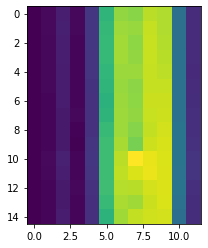

In [6]:
plt.imshow(train_images[1,1,:,:])

In [7]:
train_images = train_images.transpose(0,3,1,2)

In [8]:
train_images[1,1,:,:].shape

(15, 15)

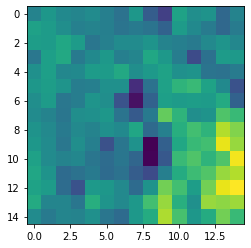

In [9]:
plt.imshow(train_images[1,1,:,:])

## Extracting Data from keys

In [10]:
# train
train_images = np.array(trainset['images'],dtype=np.float64)
train_images = train_images.transpose(0,3,1,2)
train_biomasses = np.array(trainset['agbd'],dtype=np.float64)
train_cloud = np.array(trainset['cloud'],dtype=np.float64)
train_lat = np.array(trainset['lat'],dtype=np.float64)
train_lon = np.array(trainset['lon'],dtype=np.float64)
train_scl = np.array(trainset['scl'],dtype=np.float64)


# validate
validate_images = np.array(validateset['images'],dtype=np.float64)
validate_images = validate_images.transpose(0,3,1,2)
validate_biomasses = np.array(validateset['agbd'],dtype=np.float64)
validate_cloud = np.array(validateset['cloud'],dtype=np.float64)
validate_lat = np.array(validateset['lat'],dtype=np.float64)
validate_lon = np.array(validateset['lon'],dtype=np.float64)
validate_scl = np.array(validateset['scl'],dtype=np.float64)

# test 
test_images = np.array(testset['images'],dtype=np.float32)
test_images = test_images.transpose(0,3,1,2)
test_biomasses = np.array(testset['agbd'],dtype=np.float32)
test_cloud = np.array(testset['cloud'],dtype=np.float32)
test_lat = np.array(testset['lat'],dtype=np.float32)
test_lon = np.array(testset['lon'],dtype=np.float32)
test_scl = np.array(testset['scl'],dtype=np.float32)

# First Baseline With Sklearn

In [11]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

In [12]:
from sklearn import set_config
set_config(display='diagram')

## Creating train df

In [13]:
def df_creator(df, name):
    lon_df_train = pd.DataFrame(df.reshape(df.shape[0], -1))
    column_names = ['col'+str(i) for i in range(df.shape[1]*df.shape[2]*df.shape[3])]
    lon_df_train.columns = column_names
    new_column_names = {col: name + col[3:] for col in lon_df_train.columns if col.startswith("col")}
    lon_df_train = lon_df_train.rename(columns=new_column_names)
    return lon_df_train

In [14]:
#Converting to tabular solution
#longitude data
lon_df_train = df_creator(train_lon, "lon")
#latitude data
lat_df_train = df_creator(train_lat, "lat")
scl_df = df_creator(train_scl, "scl")
cloud_df_train = df_creator(train_cloud, "cloud")
train_df = df_creator(train_images, "pix")

In [15]:
#joining the scl df
train_df = pd.concat([train_df, scl_df, cloud_df_train, lat_df_train, lon_df_train], axis=1)

In [16]:
train_df["Biomass"] = train_biomasses

In [17]:
train_df.head()

,pix0,pix1,pix2,pix3,pix4,pix5,pix6,pix7,pix8,pix9,...,lon216,lon217,lon218,lon219,lon220,lon221,lon222,lon223,lon224,Biomass
0,283.0,283.0,286.0,291.0,298.0,308.0,321.0,336.0,353.0,373.0,...,-3.528877,-3.528786,-3.528695,-3.528605,-3.528514,-3.528424,-3.528333,-3.528243,-3.528152,10.646117
1,175.0,175.0,175.0,175.0,175.0,175.0,175.0,175.0,175.0,175.0,...,-2.940830,-2.940739,-2.940648,-2.940557,-2.940466,-2.940376,-2.940285,-2.940194,-2.940104,99.101875
2,321.0,320.0,318.0,318.0,320.0,325.0,330.0,336.0,342.0,345.0,...,-5.455712,-5.455622,-5.455531,-5.455440,-5.455349,-5.455258,-5.455167,-5.455077,-5.454986,30.911081
3,319.0,319.0,320.0,322.0,325.0,328.0,330.0,332.0,333.0,334.0,...,-5.455440,-5.455349,-5.455258,-5.455167,-5.455077,-5.454986,-5.454895,-5.454804,-5.454713,14.941122
4,311.0,311.0,311.0,311.0,313.0,315.0,319.0,323.0,327.0,330.0,...,-5.455167,-5.455077,-5.454986,-5.454895,-5.454804,-5.454713,-5.454622,-5.454532,-5.454441,18.502295


## Creating validation df

In [18]:
#Converting to tabular solution
#latitude data
lat_df_valid = df_creator(validate_lat, "lat")
#longitude data
lon_df_valid = df_creator(validate_lon, "lon")
scl_df_valid = df_creator(validate_scl, "scl")
cloud_df_valid = df_creator(validate_cloud, "cloud")
valid_df = df_creator(validate_images, "pix")

In [19]:
#joining the scl df
valid_df = pd.concat([valid_df, scl_df_valid, cloud_df_valid, lat_df_valid, lon_df_valid], axis=1)

In [20]:
valid_df["Biomass"] = validate_biomasses

In [21]:
valid_df.head()

,pix0,pix1,pix2,pix3,pix4,pix5,pix6,pix7,pix8,pix9,...,lon216,lon217,lon218,lon219,lon220,lon221,lon222,lon223,lon224,Biomass
0,354.0,353.0,353.0,353.0,353.0,352.0,352.0,352.0,351.0,351.0,...,-5.623662,-5.623571,-5.623480,-5.623390,-5.623299,-5.623208,-5.623117,-5.623026,-5.622935,12.375340
1,354.0,354.0,354.0,354.0,354.0,354.0,354.0,353.0,352.0,351.0,...,-5.623299,-5.623208,-5.623117,-5.623026,-5.622935,-5.622845,-5.622754,-5.622663,-5.622572,62.468437
2,374.0,371.0,368.0,366.0,364.0,363.0,362.0,361.0,360.0,360.0,...,-5.623026,-5.622935,-5.622845,-5.622754,-5.622663,-5.622572,-5.622481,-5.622391,-5.622300,33.439976
3,752.0,749.0,742.0,731.0,715.0,694.0,667.0,631.0,588.0,541.0,...,-3.269590,-3.269500,-3.269409,-3.269318,-3.269228,-3.269137,-3.269047,-3.268956,-3.268866,60.226604
4,404.0,404.0,404.0,404.0,405.0,406.0,406.0,407.0,407.0,407.0,...,-4.397312,-4.397222,-4.397131,-4.397041,-4.396950,-4.396860,-4.396769,-4.396679,-4.396588,14.945768


## Splitting into trains and valiations

In [22]:
# assume your DataFrame is called 'df'
X_train = train_df.drop("Biomass", axis=1)
y_train = train_df["Biomass"]

X_valid = valid_df.drop("Biomass", axis=1)
y_valid = valid_df["Biomass"]

## Feature Selection

Takes a little long to run, high dimensionality

In [23]:
#from sklearn.linear_model import LassoCV

# Define the model with L1 regularization
#lasso = LassoCV()

# Fit the model
#lasso.fit(X_train, y_train)

In [24]:
#selected_columns = X_train.columns[lasso.coef_ != 0]

In [25]:
#selected_columns

## Standardising df values

In [26]:
#X_train = X_train[selected_columns]
#X_valid = X_valid[selected_columns]

In [27]:
from sklearn.preprocessing import StandardScaler
# define standard scaler
scaler = StandardScaler()
  
# transform data
X_train = scaler.fit_transform(X_train)
#y_train = scaler.fit_transform(y_train)
X_valid = scaler.fit_transform(X_valid)
#y_valid = scaler.fit_transform(y_valid)

In [28]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# fit a linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [29]:
predictions = regressor.predict(X_valid)

In [30]:
predictions

array([-24.70735027,  23.19529775,  34.8885051 , ...,  39.27094523,
        84.10895823,  35.23437215])

In [31]:
y_valid

0       12.375340
1       62.468437
2       33.439976
3       60.226604
4       14.945768
          ...    
5169    16.261654
5170    25.115419
5171    34.509979
5172    14.634684
5173    36.461483
Name: Biomass, Length: 5174, dtype: float64

In [32]:
mse = mean_squared_error(y_valid, abs(predictions))

In [33]:
(mse)**(1/2)

62.89566831067269

### Gridsearch

In [34]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet
param1 = {}
param1['classifier'] = [LinearRegression()]

param2 = {}
param2['classifier__alpha'] = [0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 1]
param2['classifier'] = [Ridge()]

param3 = {}
param3['classifier__alpha'] = [00.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 1]
param3['classifier'] = [Lasso()]

param4 = {}
param4['classifier__n_neighbors'] = [2,5,10,25,50]
param4['classifier'] = [KNeighborsRegressor()]

param5 = {}
param5['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param5['classifier__epsilon'] = [0.0,0.2,0.5,1]
param5['classifier'] = [LinearSVR()]

#param6 = {}
#param6['classifier'] = [ElasticNet()]

#param7 = {}
#param7['classifier'] = [DecisionTreeRegressor()]
#param7['classifier__max_depth'] = [None, 5, 10, 20]
#param7['classifier__min_samples_split'] = [2, 5, 10]
#param7['classifier__min_samples_leaf'] = [1, 2, 4]

#param8 = {}
#param8['classifier'] = [RandomForestRegressor()]
#param8['classifier__n_estimators'] = [10, 50, 100, 200]
#param8['classifier__max_depth'] = [None, 5, 10, 20]
#param8['classifier__min_samples_split'] = [2, 5, 10]
#param8['classifier__min_samples_leaf'] = [1, 2, 4]

#param9 = {}
#param9['classifier'] = [GradientBoostingRegressor()]
#param9['classifier__n_estimators'] = [10, 50, 100, 200]
#param9['classifier__learning_rate'] = [0.01, 0.1, 1]
#param9['classifier__max_depth'] = [3, 5, 10]

In [36]:
pipeline = Pipeline(steps=[
                       ("classifier", LinearRegression())])
#Full param list
#params = [param1, param2, param3, param4, param5, param6, param7, param8, param9]
params = [param1, param2, param3, param4, param5]

In [37]:
grid_search = GridSearchCV(pipeline, params, cv=3, scoring='neg_mean_squared_error').fit(X_train,y_train)

KeyboardInterrupt: 

In [ ]:
grid_search.best_params_

In [ ]:
model = grid_search.best_estimator_
# predict
pred = model.predict(X_valid)

In [ ]:
pred

In [ ]:
mse = mean_squared_error(y_valid, abs(pred))

In [ ]:
mse**(1/2)

### Predict GIZ Biomass

In [ ]:
s2_images_file = h5py.File("../Data/TestFiles/images_test.h5", "r")
s2_cloud_file = h5py.File("../Data/TestFiles/cloud_test.h5", "r")
s2_lat_file = h5py.File("../Data/TestFiles/lat_test.h5", "r")
s2_lon_file = h5py.File("../Data/TestFiles/lon_test.h5", "r")
s2_scl_file = h5py.File("../Data/TestFiles/scl_test.h5", "r")

In [ ]:
s2_images = np.array(s2_images_file['images'],dtype=np.float64)
s2_images = s2_images.transpose(0,3,1,2)
s2_cloud = np.array(s2_cloud_file['cloud'],dtype=np.float64)
s2_lat = np.array(s2_lat_file['lat'],dtype=np.float64)
s2_lon = np.array(s2_lon_file['lon'],dtype=np.float64)
s2_scl = np.array(s2_scl_file['scl'],dtype=np.float64)

## Creating the S2 test dataframe

In [ ]:
s2_images_df = df_creator_creator(s2_images, "pix")
s2_cloud_df = df_creator(s2_cloud, "cloud")
s2_lat_df = df_creator(s2_lat, "lat")
s2_lon_df = df_creator(s2_lon, "lon")
s2_scl_df = df_creator(s2_scl, "scl")

In [ ]:
#joining the scl df
s2_df = pd.concat([s2_images_df, s2_cloud_df, s2_lat_df, s2_lon_df, s2_scl_df], axis=1)

In [ ]:
s2_df.head()

In [ ]:
s2 = scaler.fit_transform(s2_df)

In [ ]:
# predict on giz test data
pred_giz = model.predict(s2)

In [ ]:
pred_giz = abs(pred_giz)

In [ ]:
pred_giz

In [ ]:
ID_S2_pair = pd.read_csv('../Data/UniqueID-SentinelPair.csv')
preds = pd.DataFrame({'Target':pred_giz}).rename_axis('S2_idx').reset_index()
preds = ID_S2_pair.merge(preds, on='S2_idx').drop(columns=['S2_idx'])

In [ ]:
preds.to_csv('../Submissions/Baseline1.csv', index=False)